# 1. Daily closing prices for Facebook

## Obtain and plot price data

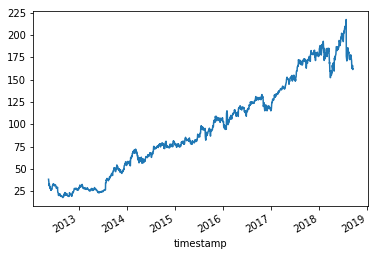

In [4]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, solve, det

r = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&apikey=83SCGSM1BQW0WE86&datatype=csv')
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=FB&outputsize=full&apikey=83SCGSM1BQW0WE86&datatype=csv'
source = requests.get(url).content.decode().split("\n")

data = pd.read_csv(url, index_col=0, parse_dates=True)
data.head()
data['close'].plot()
plt.show()

In [11]:
# Further data work and saving to .csv

data.head()
data.to_csv('FBprices.csv')

**Notes and current to-dos:**

* (DONE) Store dataset
* More companies (note can only request from Alpha Vantage five times every min)
* Update and store data in a structured, separate panel dataset created by the queries that is regularly updated - initial work will happen on this
* Basic summary stats for prices - this will later become an indicator table
* Non-price indicators, e.g. other financial data (may have to pull this from another source)

## Estimation

In [164]:
## Variable creation

# Column vector of ones (intercept)

data['const'] = 1

# Time counter

data['t'] = range(len(data['const']))

# Containers for the non-linear parameters

data['tc'] = len(data['const'])+1 # currently tomorrow
data['m'] = np.random.uniform(0, 1) # recommended filter bound
data['ω'] = np.random.randint(4, 26) # recommended filter bound; integers for simplicity

# Dependent variables (f, g, and h)

data['f'] = (data['tc']-data['t'])**data['m']
data['g'] = ((data['tc']-data['t'])**data['m'])*np.cos(data['ω']*np.log(data['tc']-data['t']))
data['h'] = ((data['tc']-data['t'])**data['m'])*np.sin(data['ω']*np.log(data['tc']-data['t']))

## Slaving the linear parameters (OLS estimates)

X = np.array([data['const'], data['f'], data['g'], data['h']]).T
p = np.array([data['close']]).T
y = np.log(p)

β_hat = inv(X.T @ X) @ X.T @ y

# Extracting slaved linear parameter estimates

A_hat = β_hat[0]
B_hat = β_hat[1]
C_1_hat = β_hat[2]
C_2_hat = β_hat[3]

print(β_hat)
print(C_1_hat) # to see if this worked

##SPARE CODE BEGINS HERE

#Reminder code for deleting variable

#del df['column_name']

#Optional container code

#nonlinparams = ['tc', 'm', 'ω']

#for i in nonlinparams:
 #   data[i] = np.random.randint(1, 4)

[[2.34691796e+00]
 [1.13618748e-01]
 [1.31972738e-04]
 [1.69595242e-03]]
[0.00013197]


## LPPL math - working

Want to implement the following:
    
$ln(p_{t}) = LPPL(\phi,t) = A + B(f) + C_{1}(g) + C_{2}(h)$

Where $\phi = $

(Up to here)